## <font color=#6B49F5> A Simple Implementation of FedAvg with PyTorch on Non-IID Data </font> 
Please see https://towardsdatascience.com/federated-learning-a-simple-implementation-of-fedavg-federated-averaging-with-pytorch-90187c9c9577 for more details.

* Added dirichlet distribution in get_subsamples_indices_new
* Added random sampling in selected layers, random_sampling_nodes
* Modified the Ploting for 2 nodes in same location in IID and Non-IID model disctionaries
* After plots saved, outputs the video in mp4 format

In [1]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import random
import math
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
import matplotlib

from pathlib import Path
import requests
import pickle
import gzip

import torch
import math
import torch.nn.functional as F
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.mixture import GaussianMixture
from datetime import datetime 
from datetime import date
import os

pd.options.display.float_format = "{:,.4f}".format

In [2]:
# Let's download data set
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"
# PATH = os.join.path(p1, p2)
PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), (x_test, y_test)) = pickle.load(f, encoding="latin-1")

In [4]:
# Let's see the dataset size
x_train.shape, y_train.shape , x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((50000, 784), (50000,), (10000, 784), (10000,), (10000, 784), (10000,))

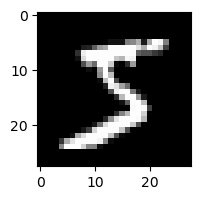

In [5]:
# check the first X train data (28*28 = 784)
plt.figure(figsize=(2,2))
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
plt.show()

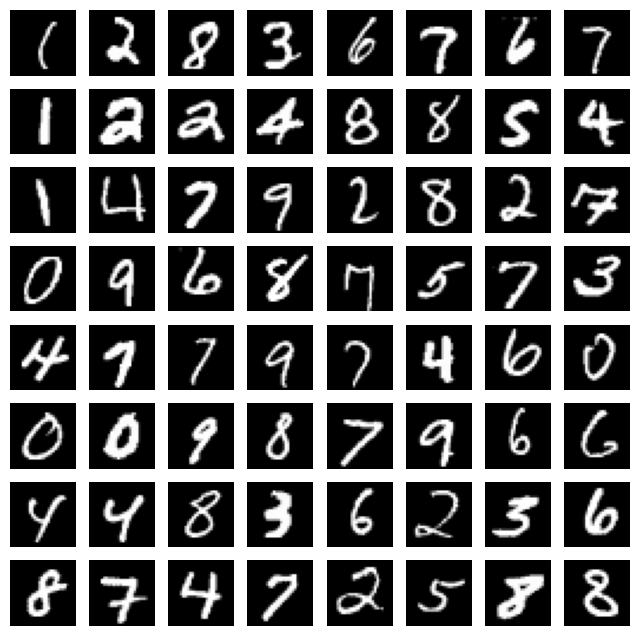

In [6]:
fig, axes = plt.subplots(8,8,figsize=(8,8))
for i in range(8):
    for j in range(8):
        num_index = np.random.randint(len(x_train))
        axes[i,j].imshow(x_train[num_index].reshape((28,28)), cmap="gray")
        axes[i,j].axis("off")
plt.show() 

**Let's check how many of each tag are**

In [7]:
# Let's check how many of each tag are.
y_train_total=0
y_valid_total=0
y_test_total=0
total=0
for i in range(10):
    print(i,">> train:", sum(y_train==i), ", valid:", sum(y_valid==i), 
          ", test:", sum(y_test==i), ", total:", sum(y_train==i)+sum(y_valid==i)+sum(y_test==i) )
    
    y_train_total=y_train_total + sum(y_train==i)
    y_valid_total=y_valid_total + sum(y_valid==i)
    y_test_total=y_test_total + sum(y_test==i)
    total=total+sum(y_train==i)+sum(y_valid==i)+sum(y_test==i)
    
print("y_train_total=", y_train_total) 
print("y_valid_total=", y_valid_total) 
print("y_test_total=", y_test_total)
print("total=", total)

0 >> train: 4932 , valid: 991 , test: 980 , total: 6903
1 >> train: 5678 , valid: 1064 , test: 1135 , total: 7877
2 >> train: 4968 , valid: 990 , test: 1032 , total: 6990
3 >> train: 5101 , valid: 1030 , test: 1010 , total: 7141
4 >> train: 4859 , valid: 983 , test: 982 , total: 6824
5 >> train: 4506 , valid: 915 , test: 892 , total: 6313
6 >> train: 4951 , valid: 967 , test: 958 , total: 6876
7 >> train: 5175 , valid: 1090 , test: 1028 , total: 7293
8 >> train: 4842 , valid: 1009 , test: 974 , total: 6825
9 >> train: 4988 , valid: 961 , test: 1009 , total: 6958
y_train_total= 50000
y_valid_total= 10000
y_test_total= 10000
total= 70000


In [8]:
def split_and_shuffle_labels(y_data, seed, amount):
    y_data=pd.DataFrame(y_data,columns=["labels"]) # create DF on all y values
    y_data["i"]=np.arange(len(y_data)) # create a global index
    label_dict = dict()
    for i in range(10):
        var_name="label" + str(i)
        label_info=y_data[y_data["labels"]==i] # create an index for each class
        np.random.seed(seed)
        label_info=np.random.permutation(label_info)
        label_info=label_info[0:amount]
        label_info=pd.DataFrame(label_info, columns=["labels","i"])
        label_dict.update({var_name: label_info })
    return label_dict

In [9]:
def get_subsamples_indices(label_dict, number_of_samples, amount, NonIID = False):
    sample_dict= dict()
    batch_size=int(math.floor(amount/number_of_samples)) # 45
    
    # sample 5 out of the 10 figures, two groups a and b
    non_iid_classes_a = random.sample([*range(0,10,1)], 5)
    non_iid_classes_b = list(set([*range(0,10,1)]) - set(non_iid_classes_a))
    for i in range(number_of_samples): # create 100 number_of_samples
        sample_name="sample"+str(i)
        dumb=pd.DataFrame()
        if NonIID:
            # Non-IID distribution, each sample only gets 5 classes
            if i % 2 == 0:
                # i is even, use group a's class
                for j in non_iid_classes_a:
                    label_name=str("label")+str(j)
                    a=label_dict[label_name][i*batch_size:(i+2)*batch_size]
                    dumb=pd.concat([dumb,a], axis=0)
            else:    
                for j in non_iid_classes_b:
                    label_name=str("label")+str(j)
                    a=label_dict[label_name][i*batch_size:(i+2)*batch_size]
                    dumb=pd.concat([dumb,a], axis=0)         
        else:
            # IID distribution, each number class gets same samples
            for j in range(10): # for each number 0 - 9
                label_name=str("label")+str(j)
                a=label_dict[label_name][i*batch_size:(i+1)*batch_size] # get 45 record of one number 
                dumb=pd.concat([dumb,a], axis=0) # concat total 10 of them 0 - 9
        dumb.reset_index(drop=True, inplace=True)    
        sample_dict.update({sample_name: dumb}) # each sample 450, 100 samples
    return sample_dict

In [10]:
def get_subsamples_indices_new(label_dict, number_of_samples, amount, NonIID = False, alpha=0.9):
    sample_dict= dict()
    batch_size=int(math.floor(amount/number_of_samples)) # 45
    no_classes = 10
    
    if NonIID == False:
        for i in range(number_of_samples): # create 100 number_of_samples
            sample_name="sample"+str(i)
            dumb=pd.DataFrame()
            # IID distribution, each number class gets same samples
            for j in range(no_classes): # for each number 0 - 9
                label_name=str("label")+str(j)
                a=label_dict[label_name][i*batch_size:(i+1)*batch_size] # get 45 record of one number 
                dumb=pd.concat([dumb,a], axis=0) # concat total 10 of them 0 - 9
            dumb.reset_index(drop=True, inplace=True)    
            sample_dict.update({sample_name: dumb}) # each sample 450, 100 samples
    else:
        # based of dirichlet distribution
        #print("label_dict", label_dict)
        image_nums = []
        sample_dict = {}
        
        for i in range (number_of_samples):
            sample_name="sample"+str(i)
            sample_dict.update({sample_name: pd.DataFrame()})
        
        for label in range (no_classes):
            image_num = []
            sampled_probabilities = amount * np.random.dirichlet(
                np.array(number_of_samples * [alpha]))
            class_label_len = len(label_dict[str("label")+str(label)])
            # print("class_label_len", class_label_len)
            
            for sample in range(number_of_samples):
                # print("sample", sample)
                dumb2 = pd.DataFrame()
                no_imgs = int(round(sampled_probabilities[sample]))
                label_name=str("label")+str(label)

                sampled_list = label_dict[label_name][:min(class_label_len, no_imgs)]
                image_num.append(len(sampled_list))
                dumb2=pd.concat([dumb2, sampled_list], axis=0)
                
                class_label_len = class_label_len - len(sampled_list)
                # print("user", user)
                # print("no_imgs", no_imgs)
                # print("class_label_len", class_label_len)
                sample_name="sample"+str(sample)
                image_nums.append(image_num)
                # print("dumb2", dumb2)
                # print("label_name", label_name)
                # print("[dumb[label_name]", dumb[label_name])
                #dumb.reset_index(drop=True, inplace=True)
                sample_dict[sample_name] = pd.concat([sample_dict[sample_name], dumb2])
        # self.draw_dirichlet_plot(10, number_of_samples,image_nums, alpha)
    return sample_dict

In [39]:
def create_subsamples(sample_dict, x_data, y_data, x_name, y_name):
    x_data_dict= dict()
    y_data_dict= dict()
    
    for i in range(len(sample_dict)):  ### len(sample_dict)= number of samples 100
        xname= x_name+str(i)
        yname= y_name+str(i)
        sample_name="sample"+str(i)
        
        # use the global index to reconnect x and y
        indices=np.sort(np.array(sample_dict[sample_name]["i"])) 
        
        x_info= x_data[indices,:]
        x_data_dict.update({xname : x_info})
        
        y_info= y_data[indices]
        y_data_dict.update({yname : y_info})
        
    return x_data_dict, y_data_dict

--------------------------
### <span style="background-color:#F087F9"> Classification Model </span> 

In [12]:
class Net2nn(nn.Module):
    def __init__(self):
        super(Net2nn, self).__init__()
        self.fc1=nn.Linear(784,200)
        self.fc2=nn.Linear(200,200)
        self.fc3=nn.Linear(200,10)
        
    def forward(self,x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

In [13]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [14]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0

    for data, target in train_loader:
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        prediction = output.argmax(dim=1, keepdim=True)
        correct += prediction.eq(target.view_as(prediction)).sum().item()
        

    return train_loss / len(train_loader), correct/len(train_loader.dataset)

In [15]:
def validation(model, test_loader, criterion):
    # print("validation len(test_loader)", test_loader)
    # <torch.utils.data.dataloader.DataLoader object at 0x000002E9693503C8>
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            
            test_loss += criterion(output, target).item()
            prediction = output.argmax(dim=1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    test_loss /= len(test_loader)
    correct /= len(test_loader.dataset)

    return (test_loss, correct)

---------------------------------
### <span style="background-color:#F087F9"> Functions for Federated Averaging </span> 

In [16]:
def create_model_optimizer_criterion_dict(number_of_samples):
    model_dict = dict()
    optimizer_dict= dict()
    criterion_dict = dict()
    
    for i in range(number_of_samples):
        model_name="model"+str(i)
        model_info=Net2nn()
        model_dict.update({model_name : model_info })
        
        optimizer_name="optimizer"+str(i)
        optimizer_info = torch.optim.SGD(model_info.parameters(), lr=learning_rate, momentum=momentum)
        optimizer_dict.update({optimizer_name : optimizer_info })
        
        criterion_name = "criterion"+str(i)
        criterion_info = nn.CrossEntropyLoss()
        criterion_dict.update({criterion_name : criterion_info})
        
    return model_dict, optimizer_dict, criterion_dict 

In [17]:
def get_averaged_weights(model_dict, number_of_samples):
   
    fc1_mean_weight = torch.zeros(size=model_dict[name_of_models[0]].fc1.weight.shape)
    fc1_mean_bias = torch.zeros(size=model_dict[name_of_models[0]].fc1.bias.shape)
    
    fc2_mean_weight = torch.zeros(size=model_dict[name_of_models[0]].fc2.weight.shape)
    fc2_mean_bias = torch.zeros(size=model_dict[name_of_models[0]].fc2.bias.shape)
    
    fc3_mean_weight = torch.zeros(size=model_dict[name_of_models[0]].fc3.weight.shape)
    fc3_mean_bias = torch.zeros(size=model_dict[name_of_models[0]].fc3.bias.shape)
    
    with torch.no_grad():
    
    
        for i in range(number_of_samples):
            fc1_mean_weight += model_dict[name_of_models[i]].fc1.weight.data.clone()
            fc1_mean_bias += model_dict[name_of_models[i]].fc1.bias.data.clone()
        
            fc2_mean_weight += model_dict[name_of_models[i]].fc2.weight.data.clone()
            fc2_mean_bias += model_dict[name_of_models[i]].fc2.bias.data.clone()
        
            fc3_mean_weight += model_dict[name_of_models[i]].fc3.weight.data.clone()
            fc3_mean_bias += model_dict[name_of_models[i]].fc3.bias.data.clone()

        
        fc1_mean_weight =fc1_mean_weight/number_of_samples
        fc1_mean_bias = fc1_mean_bias/ number_of_samples
    
        fc2_mean_weight =fc2_mean_weight/number_of_samples
        fc2_mean_bias = fc2_mean_bias/ number_of_samples
    
        fc3_mean_weight =fc3_mean_weight/number_of_samples
        fc3_mean_bias = fc3_mean_bias/ number_of_samples
    
    return fc1_mean_weight, fc1_mean_bias, fc2_mean_weight, fc2_mean_bias, fc3_mean_weight, fc3_mean_bias

In [18]:
def set_averaged_weights_as_main_model_weights_and_update_main_model(main_model, model_dict, number_of_samples):
    fc1_mean_weight, fc1_mean_bias, fc2_mean_weight, fc2_mean_bias, fc3_mean_weight, fc3_mean_bias = get_averaged_weights(model_dict, number_of_samples=number_of_samples)
    with torch.no_grad():
        main_model.fc1.weight.data = fc1_mean_weight.data.clone()
        main_model.fc2.weight.data = fc2_mean_weight.data.clone()
        main_model.fc3.weight.data = fc3_mean_weight.data.clone()

        main_model.fc1.bias.data = fc1_mean_bias.data.clone()
        main_model.fc2.bias.data = fc2_mean_bias.data.clone()
        main_model.fc3.bias.data = fc3_mean_bias.data.clone() 
    return main_model

In [19]:
def compare_local_and_merged_model_performance(number_of_samples, model_dict):
    if model_dict == model_dict_1:
        x_test_dict = x_test_dict_noniid
        y_test_dict = y_test_dict_noniid
        criterion_dict = criterion_dict_1
        optimizer_dict = optimizer_dict_1
        main_criterion = main_criterion_1
        main_model = main_model_1
    elif model_dict == model_dict_2:
        x_test_dict = x_test_dict_iid
        y_test_dict = y_test_dict_iid
        criterion_dict = criterion_dict_2
        optimizer_dict = optimizer_dict_2
        main_criterion = main_criterion_2
        main_model = main_model_2        
        
    accuracy_table=pd.DataFrame(data=np.zeros((number_of_samples,3)), columns=["sample", "local_ind_model", "merged_main_model"])
    for i in range (number_of_samples):

        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]

        # print("len(test_dl)", test_dl)
        individual_loss, individual_accuracy = validation(model, test_dl, criterion)
        main_loss, main_accuracy =validation(main_model, test_dl, main_criterion )

        accuracy_table.loc[i, "sample"]="sample "+str(i)
        accuracy_table.loc[i, "local_ind_model"] = individual_accuracy
        accuracy_table.loc[i, "merged_main_model"] = main_accuracy

    return accuracy_table

In [20]:
def send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples):
    with torch.no_grad():
        for i in range(number_of_samples):

            model_dict[name_of_models[i]].fc1.weight.data =main_model.fc1.weight.data.clone()
            model_dict[name_of_models[i]].fc2.weight.data =main_model.fc2.weight.data.clone()
            model_dict[name_of_models[i]].fc3.weight.data =main_model.fc3.weight.data.clone() 
            
            model_dict[name_of_models[i]].fc1.bias.data =main_model.fc1.bias.data.clone()
            model_dict[name_of_models[i]].fc2.bias.data =main_model.fc2.bias.data.clone()
            model_dict[name_of_models[i]].fc3.bias.data =main_model.fc3.bias.data.clone() 
    
    return model_dict

In [21]:
def start_train_end_node_process_double(number_of_samples, if_print, print_amount, sample_list, iteration):

    x_train_dict1 = x_train_dict_noniid
    y_train_dict1 = y_train_dict_noniid
    x_test_dict1 = x_test_dict_noniid
    y_test_dict1 = y_test_dict_noniid
    criterion_dict1 = criterion_dict_1
    optimizer_dict1 = optimizer_dict_1
    model_dict1 = model_dict_1

    x_train_dict2 = x_train_dict_iid
    y_train_dict2 = y_train_dict_iid
    x_test_dict2 = x_test_dict_iid
    y_test_dict2 = y_test_dict_iid
    criterion_dict2 = criterion_dict_2
    optimizer_dict2 = optimizer_dict_2
    model_dict2 = model_dict_2
    
    # print("batch_size", batch_size) # 32
    for i in range (number_of_samples): 
        # Non-iid
        train_ds1 = TensorDataset(x_train_dict1[name_of_x_train_sets[i]], y_train_dict1[name_of_y_train_sets[i]])
        # print("len of train_ds1", len(train_ds1)) # when train_ds1 < batch_size, validation code break alpha < 0.2
        train_dl1 = DataLoader(train_ds1, batch_size=batch_size, shuffle=True)

        test_ds1 = TensorDataset(x_test_dict1[name_of_x_test_sets[i]], y_test_dict1[name_of_y_test_sets[i]])
        test_dl1 = DataLoader(test_ds1, batch_size= batch_size * 2)
    
        model1=model_dict1[name_of_models[i]]
        criterion1=criterion_dict1[name_of_criterions[i]]
        optimizer1=optimizer_dict1[name_of_optimizers[i]]
        
        # for iid
        train_ds2 = TensorDataset(x_train_dict2[name_of_x_train_sets[i]], y_train_dict2[name_of_y_train_sets[i]])
        train_dl2 = DataLoader(train_ds2, batch_size=batch_size, shuffle=True)

        test_ds2 = TensorDataset(x_test_dict2[name_of_x_test_sets[i]], y_test_dict2[name_of_y_test_sets[i]])
        test_dl2 = DataLoader(test_ds2, batch_size= batch_size * 2)
    
        model2=model_dict2[name_of_models[i]]
        criterion2=criterion_dict2[name_of_criterions[i]]
        optimizer2=optimizer_dict2[name_of_optimizers[i]]
        
        if if_print:
            if i<print_amount or (number_of_samples-i-1 < print_amount):
                print("Subset" ,i)
            
        for epoch in range(numEpoch):                 
            train_loss1, train_accuracy1 = train(model1, train_dl1, criterion1, optimizer1)
            test_loss1, test_accuracy1 = validation(model1, test_dl1, criterion1)
            
            train_loss2, train_accuracy2 = train(model2, train_dl2, criterion2, optimizer2)
            test_loss2, test_accuracy2 = validation(model2, test_dl2, criterion2)
            
            if if_print:
                if i<print_amount or (number_of_samples-i-1 < print_amount):        
                    print("epoch: {:3.0f}".format(epoch+1) + " | Non-iid" + " | train accuracy: {:7.5f}".format(train_accuracy1) + " | test accuracy: {:7.5f}".format(test_accuracy1)
                     + " |     iid" + " | train accuracy: {:7.5f}".format(train_accuracy2) + " | test accuracy: {:7.5f}".format(test_accuracy2))    
        # visualization
        if len(sample_list) != 0:
            for sample in sample_list:
                plot_node_weights_pair(model_dict_1, model_dict_2, sample[0], sample[1], iteration)

### Adjustable parameters

In [22]:
x_train, y_train, x_valid, y_valid,x_test, y_test = map(torch.tensor, (x_train, y_train, x_valid, y_valid, x_test, y_test))
number_of_samples=100
learning_rate = 0.01
numEpoch = 10 # 4
batch_size = 32
momentum = 0.9
alpha = 0.2 # 0.2, 0.5, 0.9, 1, 10, 100

train_amount=4500
valid_amount=900
test_amount=900
print_amount=3

## Added functions for visualization

In [23]:
def plot_node_weights_pair(model_dict_1, model_dict_2, layer, selected_weight, iteration, file_location="Plots/"):
    # create an array of the weight values|
    sample_weights_1 = []
    sample_weights_2 = []
    sample_bias_1 = []
    sample_bias_2 = []
    for i in range (number_of_samples):
        current_model = "model" + str(i)
        # w_local = model_dict[current_model].fc1.weight[selected_weight[0],selected_weight[1]].detach().numpy()
        w_local_1 = getattr(model_dict_1[current_model], layer).weight[selected_weight[0],selected_weight[1]].detach().numpy()
        w_local_2 = getattr(model_dict_2[current_model], layer).weight[selected_weight[0],selected_weight[1]].detach().numpy()
        b_local_1 = getattr(model_dict_1[current_model], layer).bias[selected_weight[0]].detach().numpy()
        b_local_2 = getattr(model_dict_2[current_model], layer).bias[selected_weight[0]].detach().numpy()
        sample_weights_1.append(w_local_1.tolist())
        sample_weights_2.append(w_local_2.tolist())
        sample_bias_1.append(b_local_1.tolist())
        sample_bias_2.append(b_local_2.tolist())

    num_bins = int(number_of_samples/4)

    # process the data with GaussianMixture model
    sample_weights_1 = np.asarray(sample_weights_1)
    sample_weights_1 = sample_weights_1.reshape(len(sample_weights_1), 1)
    sample_weights_2 = np.asarray(sample_weights_2)
    sample_weights_2 = sample_weights_2.reshape(len(sample_weights_2), 1)
    
    sample_bias_1 = np.asarray(sample_bias_1)
    sample_bias_1 = sample_bias_1.reshape(len(sample_bias_1), 1)
    sample_bias_2 = np.asarray(sample_bias_2)
    sample_bias_2 = sample_bias_2.reshape(len(sample_bias_2), 1)  

    matplotlib.use('Agg')
    # Non-IID weights
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharey=True, figsize=(20, 15))
    f.set_facecolor("lightgray")

    ax1.hist(sample_weights_1, num_bins, 
                                density = 1, 
                                color ='green',
                                alpha = 0.7)

    mu_1 = np.mean(sample_weights_1)
    ax1.axvline(mu_1, color='blue', linestyle='dashed', linewidth=1)

    # IID weights
    ax2.hist(sample_weights_2, num_bins, 
                                density = 1, 
                                color ='darkolivegreen',
                                alpha = 0.7)

    mu_2 = np.mean(sample_weights_2)
    ax2.axvline(mu_2, color='blue', linestyle='dashed', linewidth=1)
    
    x1_min = min(np.min(sample_weights_1), np.min(sample_weights_2))
    x1_max = max(np.max(sample_weights_1), np.max(sample_weights_2))
    
    ax1.set_xlim(x1_min, x1_max)
    ax2.set_xlim(x1_min, x1_max)
    
    # Non-IID Bias
    ax3.hist(sample_bias_1, num_bins, 
                            density = 1, 
                            color ='red',
                            alpha = 0.7)
    
    mu3 = np.mean(sample_bias_1)
    ax3.axvline(mu3, color='blue', linestyle='dashed', linewidth=1)
    ax3.set_title('Non-IID Bias Mean: {:.6f}'.format(mu3))
    
    # IID Bias
    ax4.hist(sample_bias_2, num_bins, 
                            density = 1, 
                            color ='brown',
                            alpha = 0.7)
    
    mu4 = np.mean(sample_bias_2)
    ax4.axvline(mu4, color='blue', linestyle='dashed', linewidth=1)
    ax4.set_title('IID Bias Mean: {:.6f}'.format(mu4))    
    
    x2_min = min(np.min(sample_bias_1), np.min(sample_bias_2))
    x2_max = max(np.max(sample_bias_1), np.max(sample_bias_2))
    
    ax3.set_xlim(x2_min, x2_max)
    ax4.set_xlim(x2_min, x2_max)
    
    
    ax1.set_title('Non-IID'+ ' (alpha: ' + str(alpha)+ ') \nWeight Mean: {:.6f}'.format(mu_1), loc='left', wrap=True)
    ax2.set_title('IID \nWeight Mean: {:.6f}'.format(mu_2), loc='left')
    plt.suptitle('Layer of: ' + layer + ', Random Weight: ' +  str(selected_weight) + ', Iter ' + str(iteration), fontsize = 'xx-large')
    f.tight_layout(rect=[0, 0.03, 1, 0.95])

    
    # create a time stamp
    today = date.today().strftime('%Y%m%d')
    now = datetime.now()
    current_time = now.strftime("%H-%M-%S")
    
    # plt.show() 
    plt_name = layer + "_" + str(selected_weight[0]) + "_" + str(selected_weight[1]) + "_I_" + \
    str(iteration) + "_" + str(today) + "_" + str(current_time) + ".png"
    
    node_folder = file_location + layer + "_" + str(selected_weight[0]) + "_" + str(selected_weight[1])
    
    if not os.path.exists(node_folder):
        os.makedirs(node_folder)
    
    plt.savefig(node_folder + '/' + plt_name)
    plt.close(f)

In [24]:
# random sampling based on parameters
def random_sampling_nodes(model, each_layer_sample_num):
    layers = []
    for name, layer in model.named_modules():
        if name != "":
            dnn_layer = getattr(model, name)
            layers.append([name, [dnn_layer.weight.size()[0], dnn_layer.weight.size()[1]]])
    # print(*layers,sep='\n')
    
    if len(each_layer_sample_num)!=len(layers):
        print("each_layer_sample_num list's length not equal to model layer list")
        return(-1)
    else:
        weights_sample = []
        for i in range(len(layers)):
            for j in range (each_layer_sample_num[i]):
                random_weight = [np.random.randint(layers[i][1][0]), np.random.randint(layers[i][1][1])]
                # print("random_weight:", random_weight)
                weights_sample.append([layers[i][0], random_weight])
    return weights_sample

----------------

### <span style="background-color:#F087F9"> Let's examine what would the performance of the centralized model be if the data were not distributed to nodes at all? </span>   

The model used in this example is very simple, different things can be done to improve model performance, such as using more complex models, increasing epoch or hyperparameter tuning. However, the purpose here is to compare the performance of the main model that is formed by combining the parameters of the local models trained on their own data with a centralized model that trained on all training data. In this way, we can gain insight into the capacity of federated learning.


In [25]:
centralized_model = Net2nn()
centralized_optimizer = torch.optim.SGD(centralized_model.parameters(), lr=0.01, momentum=0.9)
centralized_criterion = nn.CrossEntropyLoss()

In [26]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

In [27]:
print("------ Centralized Model ------")
for epoch in range(numEpoch):
    central_train_loss, central_train_accuracy = train(centralized_model, train_dl, centralized_criterion, centralized_optimizer)
    central_test_loss, central_test_accuracy = validation(centralized_model, test_dl, centralized_criterion)
    
    print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.4f}".format(central_train_accuracy) + " | test accuracy: {:7.4f}".format(central_test_accuracy))

print("------ Training finished ------")

------ Centralized Model ------
epoch:   1 | train accuracy:  0.8750 | test accuracy:  0.9491
epoch:   2 | train accuracy:  0.9564 | test accuracy:  0.9624
epoch:   3 | train accuracy:  0.9712 | test accuracy:  0.9699


KeyboardInterrupt: 

-----------------
**Data is distributed to nodes**

<!-- ### <span style="background-color:#F087F9"> Datanın nodelara dağıtılması </span>    -->

In [28]:
label_dict_train=split_and_shuffle_labels(y_data=y_train, seed=1, amount=train_amount) 
sample_dict_train_noniid=get_subsamples_indices_new(label_dict=label_dict_train, number_of_samples=number_of_samples, amount=train_amount, NonIID=True, alpha = alpha)
x_train_dict_noniid, y_train_dict_noniid = create_subsamples(sample_dict=sample_dict_train_noniid, x_data=x_train, y_data=y_train, x_name="x_train", y_name="y_train")
sample_dict_train_iid=get_subsamples_indices_new(label_dict=label_dict_train, number_of_samples=number_of_samples, amount=train_amount, NonIID=False, alpha = alpha)
x_train_dict_iid, y_train_dict_iid = create_subsamples(sample_dict=sample_dict_train_iid, x_data=x_train, y_data=y_train, x_name="x_train", y_name="y_train")


label_dict_valid = split_and_shuffle_labels(y_data=y_valid, seed=1, amount=train_amount) 
sample_dict_valid_noniid = get_subsamples_indices_new(label_dict=label_dict_valid, number_of_samples=number_of_samples, amount=valid_amount, NonIID=True, alpha = alpha)
x_valid_dict_noniid, y_valid_dict_noniid = create_subsamples(sample_dict=sample_dict_valid_noniid, x_data=x_valid, y_data=y_valid, x_name="x_valid", y_name="y_valid")
sample_dict_valid_iid = get_subsamples_indices_new(label_dict=label_dict_valid, number_of_samples=number_of_samples, amount=valid_amount, NonIID=False, alpha = alpha)
x_valid_dict_iid, y_valid_dict_iid = create_subsamples(sample_dict=sample_dict_valid_iid, x_data=x_valid, y_data=y_valid, x_name="x_valid", y_name="y_valid")

label_dict_test = split_and_shuffle_labels(y_data=y_test, seed=1, amount=test_amount) 
sample_dict_test_noniid = get_subsamples_indices_new(label_dict=label_dict_test, number_of_samples=number_of_samples, amount=test_amount, NonIID=True, alpha = alpha)
x_test_dict_noniid, y_test_dict_noniid = create_subsamples(sample_dict=sample_dict_test_noniid, x_data=x_test, y_data=y_test, x_name="x_test", y_name="y_test")
sample_dict_test_iid = get_subsamples_indices_new(label_dict=label_dict_test, number_of_samples=number_of_samples, amount=test_amount, NonIID=True, alpha = alpha)
x_test_dict_iid, y_test_dict_iid = create_subsamples(sample_dict=sample_dict_test_iid, x_data=x_test, y_data=y_test, x_name="x_test", y_name="y_test")

In [35]:
sample_dict_train_noniid['sample0'].head(1000)

,labels,i
0,0,45303
1,0,43188
2,0,2904
3,0,44325
4,0,20392
...,...,...
995,0,19225
996,0,43205
997,0,9158
998,0,25987


In [40]:
x_train_dict_noniid, y_train_dict_noniid = create_subsamples(sample_dict=sample_dict_train_noniid, x_data=x_train, y_data=y_train, x_name="x_train", y_name="y_train")

In [79]:
# check Non-IID dirichlet distribution
sample_dict_train_noniid['sample0']["labels"].value_counts()

0    2366
6      64
4      34
2      33
3      18
7       5
5       1
Name: labels, dtype: int64

torch.Size([93, 784]) torch.Size([93])
torch.Size([121, 784]) torch.Size([121])
torch.Size([28, 784]) torch.Size([28])
tensor(6)


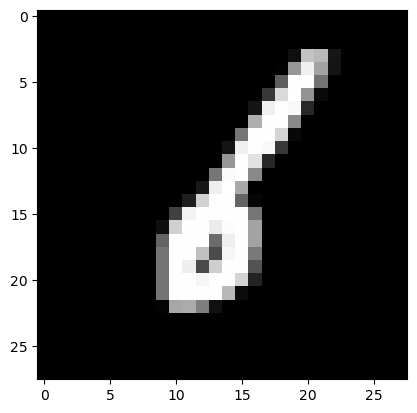

In [84]:
print(x_train_dict_noniid["x_train1"].shape, y_train_dict_noniid["y_train1"].shape)
print(x_valid_dict_noniid["x_valid1"].shape, y_valid_dict_noniid["y_valid1"].shape) 
print(x_test_dict_noniid["x_test1"].shape, y_test_dict_noniid["y_test1"].shape)

num_index = np.random.randint(test_amount/number_of_samples*10)
plt.imshow(x_test_dict_noniid["x_test0"][num_index].reshape((28,28)), cmap="gray")
print(y_test_dict_noniid["y_test0"][num_index])

### Create 2 main models

**Two Main model are created for NonIID and IID**

In [85]:
# Non-IID
main_model_1 = Net2nn()
main_optimizer_1 = torch.optim.SGD(main_model_1.parameters(), lr=learning_rate, momentum=0.9)
main_criterion_1 = nn.CrossEntropyLoss()
# IID
main_model_2 = Net2nn()
main_optimizer_2 = torch.optim.SGD(main_model_2.parameters(), lr=learning_rate, momentum=0.9)
main_criterion_2 = nn.CrossEntropyLoss()

**Models,optimizers and loss functions in nodes are defined**

In [86]:
model_dict_1, optimizer_dict_1, criterion_dict_1 = create_model_optimizer_criterion_dict(number_of_samples)
model_dict_2, optimizer_dict_2, criterion_dict_2 = create_model_optimizer_criterion_dict(number_of_samples)

In [87]:
# sync 2 models
main_model_1.fc1.weight.data = main_model_2.fc1.weight.data.clone()
main_model_1.fc2.weight.data = main_model_2.fc2.weight.data.clone()
main_model_1.fc3.weight.data = main_model_2.fc3.weight.data.clone()


main_model_1.fc1.bias.data = main_model_2.fc1.bias.data.clone()
main_model_1.fc2.bias.data = main_model_2.fc2.bias.data.clone()
main_model_1.fc3.bias.data = main_model_2.fc3.bias.data.clone() 

**Keys of dicts are being made iterable**

In [88]:
name_of_x_train_sets=list(x_train_dict_noniid.keys())
name_of_y_train_sets=list(y_train_dict_noniid.keys())
name_of_x_valid_sets=list(x_valid_dict_noniid.keys())
name_of_y_valid_sets=list(y_valid_dict_noniid.keys())
name_of_x_test_sets=list(x_test_dict_noniid.keys())
name_of_y_test_sets=list(y_test_dict_noniid.keys())

name_of_models=list(model_dict_1.keys())
name_of_optimizers=list(optimizer_dict_1.keys())
name_of_criterions=list(criterion_dict_1.keys())

# print(name_of_x_train_sets)
# print(name_of_y_train_sets)
# print(name_of_x_valid_sets)
# print(name_of_y_valid_sets)
# print(name_of_x_test_sets)
# print(name_of_y_test_sets)
# print("\n ------------")
# print(name_of_models)
# print(name_of_optimizers)
# print(name_of_criterions)

In [89]:
print(main_model_1.fc2.weight[0:1,0:5])
print(main_model_2.fc2.weight[0:1,0:5])
print(model_dict_1["model1"].fc2.weight[0:1,0:5])
print(model_dict_2["model1"].fc2.weight[0:1,0:5])

tensor([[ 0.0109,  0.0103,  0.0198, -0.0036, -0.0158]],
       grad_fn=<SliceBackward0>)
tensor([[ 0.0109,  0.0103,  0.0198, -0.0036, -0.0158]],
       grad_fn=<SliceBackward0>)
tensor([[-0.0084,  0.0565,  0.0199,  0.0383,  0.0701]],
       grad_fn=<SliceBackward0>)
tensor([[-0.0284, -0.0108,  0.0023, -0.0352,  0.0325]],
       grad_fn=<SliceBackward0>)


**Parameters of main model are sent to nodes**  
Since the parameters of the main model and parameters of all local models in the nodes are randomly initialized, all these parameters will be different from each other. For this reason, the main model sends its parameters to the nodes before the training of local models in the nodes begins. You can check the weights below.

In [90]:
model_dict_1=send_main_model_to_nodes_and_update_model_dict(main_model_1, model_dict_1, number_of_samples)
model_dict_2=send_main_model_to_nodes_and_update_model_dict(main_model_2, model_dict_2, number_of_samples)

In [91]:
# check out weights in main and local model, should be the same now
print("main models:")
print(main_model_1.fc2.weight[0:1,0:5])
print(main_model_2.fc2.weight[0:1,0:5])

print(main_model_1.fc2.bias[0:5])
print(main_model_2.fc2.bias[0:5])

print("\nmodel_dicts:")
print(model_dict_1["model1"].fc2.weight[0:1,0:5])
print(model_dict_2["model1"].fc2.weight[0:1,0:5])

print(model_dict_1["model1"].fc2.bias[0:5])
print(model_dict_2["model1"].fc2.bias[0:5])

main models:
tensor([[ 0.0109,  0.0103,  0.0198, -0.0036, -0.0158]],
       grad_fn=<SliceBackward0>)
tensor([[ 0.0109,  0.0103,  0.0198, -0.0036, -0.0158]],
       grad_fn=<SliceBackward0>)
tensor([-0.0298, -0.0124, -0.0430, -0.0046,  0.0672], grad_fn=<SliceBackward0>)
tensor([-0.0298, -0.0124, -0.0430, -0.0046,  0.0672], grad_fn=<SliceBackward0>)

model_dicts:
tensor([[ 0.0109,  0.0103,  0.0198, -0.0036, -0.0158]],
       grad_fn=<SliceBackward0>)
tensor([[ 0.0109,  0.0103,  0.0198, -0.0036, -0.0158]],
       grad_fn=<SliceBackward0>)
tensor([-0.0298, -0.0124, -0.0430, -0.0046,  0.0672], grad_fn=<SliceBackward0>)
tensor([-0.0298, -0.0124, -0.0430, -0.0046,  0.0672], grad_fn=<SliceBackward0>)


## Create a sampling selection for visualization

**Models in the nodes are trained for NonIID and IID dictionarys**

In [92]:
each_layer_list = [1,1,1]

In [93]:
sample_t = random_sampling_nodes(main_model_1, each_layer_list)

In [94]:
sample_t

[['fc1', [126, 668]], ['fc2', [143, 73]], ['fc3', [9, 169]]]

In [95]:
# Train 1 iteration
# start_train_end_node_process_double(number_of_samples, True, print_amount, sample_t, 1)

In [96]:
# check out weights in main and local model, main same, local are different
# print(main_model_1.fc2.weight[0:1,0:5])
# print(main_model_2.fc2.weight[0:1,0:5])

# print(model_dict_1["model1"].fc2.weight[0:1,0:5])
# print(model_dict_2["model1"].fc2.weight[0:1,0:5])

### checking the weights during FL training process

In [97]:
# create a loop to automate the plotting for all layers comparision

In [98]:
# iteration = 9
# for sample in sample_t:
#     plot_node_weights_pair(model_dict_1, model_dict_2, sample[0], sample[1], iteration)

### Let's compare the performance of federated main model, individual local models and centralized model  

**Federated main model vs individual local models before 1st iteration (on distributed test set)**  
Since main model is randomly initialized and no action taken on it yet, its performance is very poor. Please before_acc_table

In [99]:
# # Non-IID
# before_acc_table=compare_local_and_merged_model_performance(number_of_samples=number_of_samples, model_dict=model_dict_1)
# before_test_loss1, before_test_accuracy1 = validation(main_model_1, test_dl, main_criterion_1)

# main_model_1= set_averaged_weights_as_main_model_weights_and_update_main_model(main_model_1,model_dict_1, number_of_samples) 

# after_acc_table=compare_local_and_merged_model_performance(number_of_samples=number_of_samples, model_dict=model_dict_1)
# after_test_loss1, after_test_accuracy1 = validation(main_model_1, test_dl, main_criterion_1)

# #IID
# before_acc_table2=compare_local_and_merged_model_performance(number_of_samples=number_of_samples, model_dict=model_dict_2)
# before_test_loss2, before_test_accuracy2 = validation(main_model_2, test_dl, main_criterion_2)

# main_model_2= set_averaged_weights_as_main_model_weights_and_update_main_model(main_model_2,model_dict_2, number_of_samples) 

# after_acc_table2=compare_local_and_merged_model_performance(number_of_samples=number_of_samples, model_dict=model_dict_2)
# after_test_loss2, after_test_accuracy2 = validation(main_model_2, test_dl, main_criterion_2)

In [100]:
# print("Non-IID Federated main model vs individual local models before FedAvg first iteration")
# before_acc_table.head()

In [101]:
# print("Non-IID Federated main model vs individual local models after FedAvg first iteration")
# after_acc_table.head()

In [102]:
# print("IID Federated main model vs individual local models before FedAvg first iteration")
# before_acc_table2.head()

In [103]:
# print("IID Federated main model vs individual local models after FedAvg first iteration")
# after_acc_table2.head()

**Federated main model vs centralized model before 1st iteration (on all test data)**  
Please be aware that the centralized model gets approximately %98 accuracy on all test data.

In [104]:
# print("Before 1st iteration main model accuracy on all test data: Non-IID {:7.4f} | IID {:7.4f}".format(before_test_accuracy1, before_test_accuracy2))
# print("After 1st iteration main model accuracy on all test data: Non-IID {:7.4f} | IID {:7.4f}".format(after_test_accuracy1, after_test_accuracy2))
# print("Centralized model accuracy on all test data: {:7.4f}".format(central_test_accuracy))

This is a single iteration, we can send the weights of the main model back to the nodes and repeat the above steps.
Now let's check how the performance of the main model improves when we repeat the iteration 10 more times.

In [105]:
# records for ploting
NonIID_test_loss_records = []
NonIID_test_accuracy_records = []
IID_test_loss_records = []
IID_test_accuracy_records = []

In [116]:
for i in range(10):
    model_dict_1=send_main_model_to_nodes_and_update_model_dict(main_model_1, model_dict_1, number_of_samples)
    model_dict_2=send_main_model_to_nodes_and_update_model_dict(main_model_2, model_dict_2, number_of_samples)
    # train both Non-IID and IID model dictionaries 
    start_train_end_node_process_double(number_of_samples, False, print_amount, sample_t, i+1)
    
    main_model_1= set_averaged_weights_as_main_model_weights_and_update_main_model(main_model_1,model_dict_1, number_of_samples)
    main_model_2= set_averaged_weights_as_main_model_weights_and_update_main_model(main_model_2,model_dict_2, number_of_samples)
    
    test_loss1, test_accuracy1 = validation(main_model_1, test_dl, main_criterion_1)
    test_loss2, test_accuracy2 = validation(main_model_2, test_dl, main_criterion_2)
    
    NonIID_test_loss_records.append(test_loss1)
    NonIID_test_accuracy_records.append(test_accuracy1)
    IID_test_loss_records.append(test_loss2)
    IID_test_accuracy_records.append(test_accuracy2)
    print("Iteration", str(i+1), ": main_model accuracy on all test data: Non-iid {:7.4f}  | IID {:7.4f}".format(test_accuracy1, test_accuracy2))   

batch_size 32
len of train_ds1 2521
len of train_ds1 93
len of train_ds1 300
len of train_ds1 573
len of train_ds1 114
len of train_ds1 139
len of train_ds1 8


ZeroDivisionError: float division by zero

In [66]:
NonIID_test_loss_records

[1.883153931350465,
 0.9722915530964068,
 0.5745573281102879,
 0.45951039035608815,
 0.41874364625876115,
 0.3973537078661144,
 0.3873595784234393,
 0.38040363493191587,
 0.37534736512098343,
 0.3720674477280325]

In [67]:
NonIID_test_accuracy_records

[0.7595, 0.8388, 0.8609, 0.8697, 0.875, 0.881, 0.8827, 0.885, 0.8867, 0.8879]

In [72]:
## plot lines of loss and accuracy
plt.close()
plot_folder = "Plots"
plt_name = "accuracy.png"
plt.plot(NonIID_test_accuracy_records, label = 'Non-IID')
plt.plot(IID_test_accuracy_records, label = 'IID')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.legend()
plt.savefig(plot_folder + '/' + plt_name)
plt.close()

In [73]:
plt_name = "loss.png"
plt.plot(NonIID_test_loss_records, label ='Non-IID')
plt.plot(IID_test_loss_records, label = 'IID')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend()
plt.savefig(plot_folder + '/' + plt_name)
plt.close()

## Visualization from the plots created 

In [59]:
# create video
from moviepy.editor import *

In [75]:
def images_to_video(image_folder_path: str, fps, extension:str, video_name:str, output_format:str):
    
    import os
    import moviepy.video.io.ImageSequenceClip
    
    images = [image_folder_path+'/'+img for img in os.listdir(image_folder_path) if img.endswith(extension)]
    images.sort(key=lambda s: os.path.getmtime(os.path.join( s)))
    
    # print(images)
    movie_clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(images, fps)
    movie_clip.write_videofile(video_name+output_format,codec="libx264")

In [ ]:
for s in sample_t:
    node_name = s[0]+"_"+ str(s[1][0])+"_"+str(s[1][1])
    images_to_video("Plots/" + str(node_name), 24, ".png", node_name, ".mp4")

In [ ]:
node_name = "fc1_135_387"

In [ ]:
images_to_video("Plots/" + str(node_name), 24, ".png", node_name, ".mp4")

In [73]:
sample_t = [['fc1', [42, 15]], ['fc2', [114, 36]], ['fc3', [6, 42]]]

<!-- Iteration 2 : main_model accuracy on all test data: Non-iid  0.8661  | IID  0.8966
Iteration 3 : main_model accuracy on all test data: Non-iid  0.8735  | IID  0.9084
Iteration 4 : main_model accuracy on all test data: Non-iid  0.8785  | IID  0.9173
Iteration 5 : main_model accuracy on all test data: Non-iid  0.8808  | IID  0.9235
Iteration 6 : main_model accuracy on all test data: Non-iid  0.8831  | IID  0.9279
Iteration 7 : main_model accuracy on all test data: Non-iid  0.8832  | IID  0.9321
Iteration 8 : main_model accuracy on all test data: Non-iid  0.8837  | IID  0.9359
Iteration 9 : main_model accuracy on all test data: Non-iid  0.8851  | IID  0.9377
Iteration 10 : main_model accuracy on all test data: Non-iid  0.8864  | IID  0.9403
Iteration 11 : main_model accuracy on all test data: Non-iid  0.8864  | IID  0.9420 -->

In [45]:
# check on  fc1_42_15

In [49]:
sample_weights_1 = []
for i in range (number_of_samples):
    current_model = "model" + str(i)
    w_local_1 = getattr(model_dict_1[current_model], "fc1").weight[42,15].detach().numpy()
    sample_weights_1.append(w_local_1.tolist())

In [50]:
sample_weights_1

[-0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907692909,
 -0.004760840907

In [ ]:
# not changed during training